# QF 627 Extras - Financial Analytics
## Lesson 5 | Difference-in-Differences (DiD)

> Hi, Team 👋 Thank you for opening the script 🙂

> Tonight, we will learn the fundamentals techniques of causal inference, a critical aspect of financial analytics that allows us to understand the causal effects in our data. In particular, we will learn about difference-in-differences (`DiD`). We aim to equip you with the tools necessary to make informed decisions based on robust analytical frameworks.

## DEPENDENCIES

In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime
import re

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(2025)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

# Define our customized timer function

def countdown(Time):
    
    while Time:
        minutes, seconds = divmod(Time, 60)
        timer = "{:02d}:{:02d}".format(minutes, seconds)
        
        print(timer, end = "\r")
        time.sleep(1)
        Time -= 1
        
    print("Let us solve the problem above together :)")

## 👉 <a id = "top">Learning Pointers</a> 👈 

## [1. Difference-in-Differences](#p1)

> ### <font color = red> How do we know if the effects are driven by what you `did`? </font>

## [2. Further Exercise on DiD](#p2)

> ### <font color = red> Practice Makes Perfect :) </font>

## [3. Learning DiD with Textbook](#p3)

> ### <font color = red> Chapter 13 </font>

## [4. What We Learned & What's Next](#p4)

> ### <font color = red> Revisiting Learning Pointers </font>


## <a id = "p1">1.</a>  <font color = "green"> Difference-in-Differences (DiD) </font>  [back to table of contents](#top)

### Analytics Context

> DiD is used when a treatment, strategy, or policy is applied to a group of units (treatment group) while another group remains untreated (control group). 

> By comparing the changes in outcomes between the two groups before and after the treatment, DiD estimates the causal effect.

### Business Contexts

> DiD can be used to evaluate the impact of a training program on employee productivity or a marketing campaign on sales.

> Let's say you and your friend both operate strawberry milkshake stands and sell milkshakes daily. You use ordinary strawberries while your friend uses a special variety. After a week, you both tally your earnings from selling milkshakes. Your friend earns more as their milkshakes are more popular due to their enhanced sweetness. This represents the difference between the two groups.

> Next, after a week, you also begin using the special strawberries for making your milkshakes. After another week, both of you again record your earnings from selling milkshakes. This time, both of you earn the same amount as you are now using the same ingredients. This represents the difference-in-differences: the difference in the difference between the two groups before and after the change in ingredients.

### IMPORT

In [2]:
did_df =\
(pd
 .read_csv("https://talktoroh.com/s/marketing_did.csv")
)

In [3]:
did_df.head(3)

,deposits,madrid,barcelona
0,42,1,0
1,0,1,0
2,52,1,0


In [4]:
did_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   deposits   4600 non-null   int64
 1   madrid     4600 non-null   int64
 2   barcelona  4600 non-null   int64
dtypes: int64(3)
memory usage: 107.9 KB


### WRANGLE

In [5]:
did_df=\
(
    did_df
    .rename(columns = {"barcelona": "May"}
           )
)

did_df.head(7)

,deposits,madrid,May
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0
5,0,1,0
6,0,1,0


### Another Look of `D`ifference-`i`n-`D`ifferences

> before (0) and after (1) the strategy (treatment)

$$
    \widehat{ATE} = E[Y_1(1) - Y_0(1) | D = 1]
$$

$$
    \widehat{ATE} = E[Y(1) | D = 1] - E[Y(0)|D=1]
$$

#### Team, let's compare average deposits from Madrid before and after the campaign was implemented!

In [6]:
did_df.columns

Index(['deposits', 'madrid', 'May'], dtype='object')

In [7]:
# Average Deposit in Madrid before vs. after the marketing campaign

before_treatment =\
(
    did_df
    .query("madrid == 1 & May == 0") # denotes cell B
    .deposits # deposits
    .mean() # Average deposits from cell B
)

after_treatment =\
(
    did_df
    .query("madrid == 1 & May == 1") # denotes cell A
    .deposits # deposits
    .mean() # Average deposits from cell A
)

# Rookie Mistakes

naive_estimation_of_causal_effects = after_treatment - before_treatment
                                    #        A       -       B 

naive_estimation_of_causal_effects

np.float64(41.04775)

#### `IN`VALID Estiation of Causal Effects (Average Treatment Effects)

> `Because of the campaign (strategy) effects, you expect deposits to increase by 41 Euros per customer.`

In [8]:
# Average Deposit in Barcelona before vs. after the marketing campaign

before_control =\
(
    did_df
    .query("madrid == 0 & May == 0") # denotes cell B
    .deposits # deposits
    .mean() # Average deposits from cell B
)

after_control =\
(
    did_df
    .query("madrid == 0 & May == 1") # denotes cell A
    .deposits # deposits
    .mean() # Average deposits from cell A
)

changes_in_barcelona = after_control - before_control

#### `Valid` Estimation of Difference-in-Differences (`DiD`)

In [9]:
DiD =\
(
    (after_treatment - before_treatment) - (after_control - before_control)
    #             (A - B)                -            ( C - D )
)

DiD # 6.52 Euros

np.float64(6.524557692307688)

> `Because of the campaign (strategy) effects, you expect deposits to increase by 6.52 Euros per customer.`

### VISUALIZE

#### Matplotlib (old school)

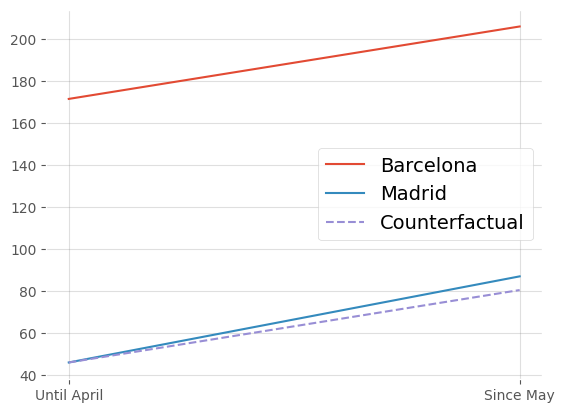

In [10]:
# CONTROL
plt\
    .plot(["Until April", "Since May"], # x-axis 
          [before_control, after_control], # y-axis
          label = "Barcelona"
         )

# TREATMENT
plt\
    .plot(["Until April", "Since May"], # x-axis 
          [before_treatment, after_treatment], # y-axis
          label = "Madrid"
         )

# COUNTER-FACTUAL "Compared with What?"
plt\
    .plot(["Until April", "Since May"],
          [before_treatment, before_treatment + (after_control - before_control)],
           ls = "--",
           label = "Counterfactual"
                             # Counterfactual --> What would have happened in May at Madrid in the absence of your marketing strategy?

          )



plt.legend()



#### Grammar of Graphics with lets-plot (cutting-edge)

In [11]:
from lets_plot import *

In [12]:
# Wrangle your data for Grammar of Graphics Plot

## matplotlib prefers wide-format data; grammar of graphics principle works better with long-format data

df_for_ggplot =\
(
    pd
    .DataFrame(
        {"treatment": ["Barcelona (Control)", "Barcelona (Control)",
                       "Madrid (Treatment)", "Madrid (Treatment)",
                       "Counterfactual", "Counterfactual"],
         "timeframe": ["Until April", "Since May",
                       "Until April", "Since May",
                       "Until April", "Since May"],
         "deposits": [before_control, after_control,
                      before_treatment, after_treatment,
                      before_treatment, before_treatment + (after_control - before_control)
                     ]
        }
    )
)

df_for_ggplot

,treatment,timeframe,deposits
0,Barcelona (Control),Until April,171.642308
1,Barcelona (Control),Since May,206.165500
2,Madrid (Treatment),Until April,46.016000
3,Madrid (Treatment),Since May,87.063750
4,Counterfactual,Until April,46.016000
5,Counterfactual,Since May,80.539192


In [13]:
LetsPlot.setup_html()

In [14]:
DiD_ggplot =\
(
    ggplot(df_for_ggplot,
           aes(x = "timeframe",
               y = "deposits",
               group = "treatment",
               color = "treatment")
          )
    + geom_point()
    + geom_line()
    + labs(title = "Difference-in-Differences Estimates for Marketing Effects",
           y = "Deposits (Unit: Euros)")
)

In [15]:
DiD_ggplot.show()

### MODEL (`How to Model DiD?`)

In [16]:
did_df.columns

Index(['deposits', 'madrid', 'May'], dtype='object')

In [17]:
import statsmodels.formula.api as smf

formal_model_of_DiD =\
(
    smf
    .ols(formula = "deposits ~ madrid * May",
         data = did_df)
    .fit()
)

formal_model_of_DiD \
    .summary()\
    .tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
madrid,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
May,34.5232,3.036,11.372,0.000,28.571,40.475
madrid:May,6.5246,5.729,1.139,0.255,-4.706,17.755


### How to formally estimate Difference-in-Differences (DiD) Estimation (with Interaction Effects)

$$
    Deposit = \alpha + \beta \text{Treatment} + \gamma \text{TimeFrame} + \delta (\text{Treatment} \times \text{TimeFrame}) + \epsilon
$$

### Advantages:

- Controls for unobserved time-invariant confounders.
<br>

- Applicable to panel data settings with treatment and control groups.

### Disadvantages:

- Assumes `parallel trends` between treatment and control groups in the absence of treatment.
<br>

- Sensitive to the choice of control group and time period.

### Team, in this circumstance, you cannot use difference-in-differences estimatation.

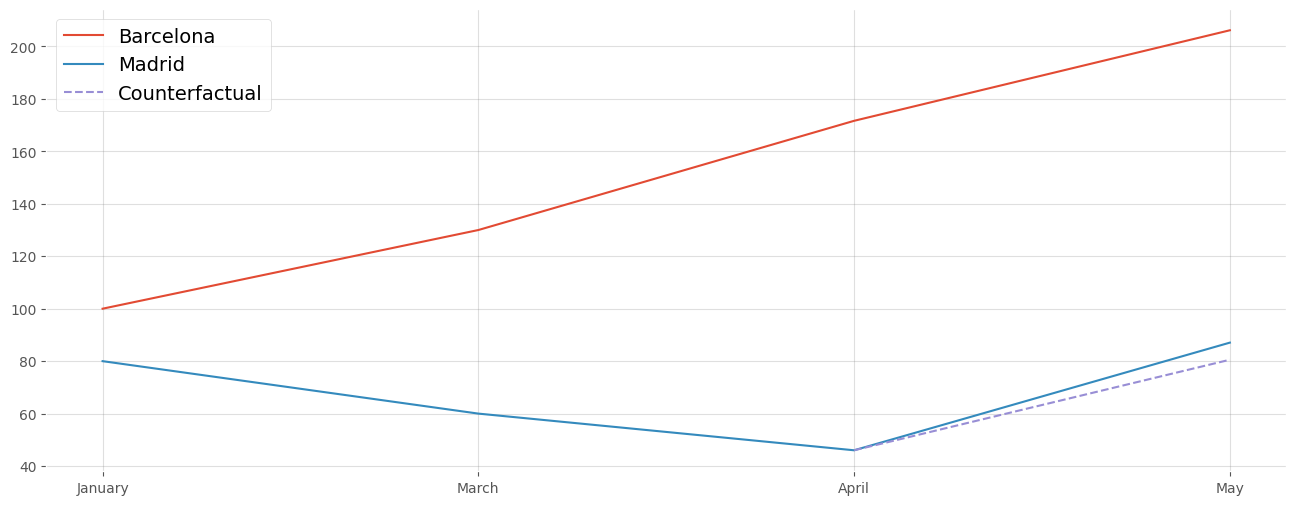

In [18]:
plt\
    .figure(figsize = [16, 6]
           )

month = ["January", "March", "April", "May"]


# CONTROL
plt\
    .plot(month, # x-axis 
          [100, 130, before_control, after_control], # y-axis
          label = "Barcelona"
         )

# TREATMENT
plt\
    .plot(month, # x-axis 
          [80, 60, before_treatment, after_treatment], # y-axis
          label = "Madrid"
         )

# COUNTER-FACTUAL "Compared with What?"
plt\
    .plot(["April", "May"],
          [before_treatment, before_treatment + (after_control - before_control)],
           ls = "--",
           label = "Counterfactual"
                             # Counterfactual --> What would have happened in May at Madrid in the absence of your marketing strategy?

          )

plt.legend()


## <a id = "p2">2.</a>  <font color = "green"> Further Exercise on DiD </font>  [back to table of contents](#top)

### Business Context

Suppose the largest city in Thailand, Bangkok, institutes a free lunch program in its elementary schools in 2015. We want to evaluate the impact of this program on students' math test scores. We also observe another large city, Ho Chi Minh City in Vietnam, which did not implement the program. Both cities' students take a standardized math test at the end of each year.

### Analytic Question

The Difference-in-Differences (DiD) method is a statistical technique used to estimate causal relationships in non-randomized settings. It compares the changes in outcomes over time between a treatment group (e.g., Bangkok) and a control group (e.g., Ho Chi Minh City).

> Key Assumptions:

* `Parallel Trends Assumption`: The treatment and control groups would have followed the same trend over time in the absence of the treatment. This means any differences between the groups before the treatment should remain constant over time if the treatment had not occurred.

* `No Other Confounding Changes`: There should be no other changes or events affecting the outcomes differently in the treatment and control groups over the study period.

### Steps to Implement DiD:

    Step 1: Define Groups and Time Periods

* `Treatment` Group: Students in Bangkok.
* `Control` Group: Students in Ho Chi Minh City.
* `Pre-Treatment` Period: 2014.
* `Post-Treatment` Period: 2016.

    Step 2: Calculate Mean Outcomes

> Compute the average test scores for each group in both periods.

    Step 3: Compute Differences

> Calculate the change in test scores over time for both groups.

    Step 4: Difference-in-Differences Estimate:

> Subtract the change in the control group from the change in the treatment group to isolate the effect of the program.

In [19]:
import statsmodels.formula.api as smf

In [20]:
# Generate synthetic data

np.random.seed(2025)

data =\
(
    pd
    .DataFrame(
        {"city": ["Bangkok"] * 100 + ["Ho Chi Minh City"] * 100,
         "year": [2014] * 50 + [2016] * 50 + [2014] * 50 + [2016] * 50,
         "test_score": np.concatenate(
             [np.random.normal(50, 10, 50),  # Bangkok 2014
              np.random.normal(120, 10, 50),  # Bangkok 2016 (after program)
              np.random.normal(50, 10, 50),  # Ho Chi Minh City 2014
              np.random.normal(90, 10, 50)   # Ho Chi Minh City 2016
             ]
         )
        }
    )
)

### Manual calculation of DiD

> Calculate the average test scores for Bangkok in 2014 and 2016, and for Ho Chi Minh City in 2014 and 2016.

> Compute the differences (d1 for Bangkok and d2 for Ho Chi Minh City).

> The DiD estimate is the difference between d1 and d2, isolating the effect of the free lunch program.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        200 non-null    object 
 1   year        200 non-null    int64  
 2   test_score  200 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


In [22]:
data.head(3)

,city,year,test_score
0,Bangkok,2014,49.076098
1,Bangkok,2014,57.342856
2,Bangkok,2014,35.611180


In [23]:
toy_df =\
(
    pd
    .DataFrame(
        {"A": [1,2,3],
         "A A A": [1,2,3]
        }
    )
)

In [24]:
toy_df

,A,A A A
0,1,1
1,2,2
2,3,3


In [25]:
toy_df[toy_df.A == toy_df["A A A"]]

,A,A A A
0,1,1
1,2,2
2,3,3


In [26]:
toy_df.query("A == `A A A`")

,A,A A A
0,1,1
1,2,2
2,3,3


In [27]:
# Control

h_2014 =\
(
    data
    [(data["city"] == "Ho Chi Minh City") & (data["year"] == 2014)
    ]
    .test_score
    .mean()
)

h_2016 =\
(
    data
    [(data["city"] == "Ho Chi Minh City") & (data["year"] == 2016)
    ]
    .test_score
    .mean()
)



In [28]:
# Treatment

b_2014 =\
(
    data
    [(data["city"] == "Bangkok") & (data["year"] == 2014) # use .query()
    ]
    .test_score
    .mean()
)

b_2016 =\
(
    data
    [(data["city"] == "Bangkok") & (data["year"] == 2016)
    ]
    .test_score
    .mean()
)

In [29]:
# difference-in-DIFFERENCES

# DIFFERENCES

difference_0 = h_2016 - h_2014

difference_1 = b_2016 - b_2014

# difference

did_manual = difference_1 - difference_0

did_manual

np.float64(23.488462022333223)

### Regression-based calculation of DiD

> Dummy variables (post, treatment, and their interaction) are added to the dataset.

> An Ordinary Least Squares (OLS) regression is performed with test_score as the dependent variable.

> The coefficient of the interaction term (interaction) represents the DiD estimate.

In [30]:
data.dtypes

city           object
year            int64
test_score    float64
dtype: object

In [31]:
data["year"] =\
(
    (data["year"] == 2016) # returns bool --> True ==> 1; False ==> 0
    .astype(int) # dummification
)

data[["year"]]

,year
0,0
1,0
2,0
3,0
4,0
...,...
195,1
196,1
197,1
198,1


In [32]:
data["city"] =\
(
    (data["city"] == "Bangkok") # returns bool --> True ==> 1; False ==> 0
    .astype(int) # dummification
)

data[["city"]]

,city
0,1
1,1
2,1
3,1
4,1
...,...
195,0
196,0
197,0
198,0


In [33]:
did_model =\
(
    smf
    .ols(formula = "test_score ~ city * year",
                                         # 2014
                                         # 2016
         data = data)
    .fit()
)

In [34]:
did_model\
    .summary()\
    .tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,49.8031,1.329,37.462,0.000,47.181,52.425
city,1.0096,1.880,0.537,0.592,-2.698,4.717
year,41.8887,1.880,22.280,0.000,38.181,45.596
city:year,23.4885,2.659,8.834,0.000,18.245,28.732


In [35]:
did_manual

np.float64(23.488462022333223)

In [36]:
did_est_from_regression =\
(
    did_model
    .params["city:year"]
)

did_est_from_regression

np.float64(23.488462022333298)

### Cross-validation of your analysis

> To assess if the manual and regression-based DiD estimates are consistent.

In [37]:
assert np.isclose(did_manual, did_est_from_regression), \
    "The manual and regression-based DiD estimations do NOT match!!!"

print("\nThe manual and regression-based DiD esimations DO MATCH! :)")


The manual and regression-based DiD esimations DO MATCH! :)


### The Big Picture

#### Difference-in-Differences (DiD) Conditions

The table below summarizes the four conditions used in the Difference-in-Differences (DiD) analysis for evaluating the free lunch program in Bangkok and Ho Chi Minh City.

| City              | Year | Test Scores | Pre/Post Period | Treatment/Control Group |
|-------------------|------|-------------|-----------------|-------------------------|
| Bangkok           | 2014 | 50          | Pre             | Treatment               |
| Bangkok           | 2016 | 120         | Post            | Treatment               |
| Ho Chi Minh City  | 2014 | 50          | Pre             | Control                 |
| Ho Chi Minh City  | 2016 | 90          | Post            | Control                 |

### The Four Groups:

- **`Pre`-Treatment Period (`2014`)**: Before the implementation of the free lunch program.
  - `Bangkok` (`Treatment` Group): Average test score is 50.
  - Ho Chi Minh City (Control Group)**: Average test score is 50.
- **`Post`-Treatment Period (`2016`)**: After the implementation of the free lunch program.
  - `Bangkok` (`Treatment` Group): Average test score is 120.
  - Ho Chi Minh City (Control Group): Average test score is 90.

### Differences Calculated:
- **Difference in Bangkok (D1)**: 
  - Post (2016) - Pre (2014) = 120 - 50 = 70
- **Difference in Ho Chi Minh City (D2)**: 
  - Post (2016) - Pre (2014) = 90 - 50 = 40

### Difference-in-Differences Estimate:
- **DiD Estimate**: 
  - D1 - D2 = 70 - 40 = 30

This estimate suggests that the free lunch program led to an average increase of 30 points in test scores for students in Bangkok, after accounting for the changes observed in the control group (Ho Chi Minh City).


> The Difference-in-Differences method leverages the parallel trends assumption to control for unobserved factors that could influence the outcome.

> By comparing changes over time between treatment and control groups, it aims to isolate the causal effect of the intervention (free lunch program) on the outcome (test scores).

> This method is particularly valuable in observational studies where randomization is not possible.

> By applying DiD, we assume that any difference in trends between the groups is attributable to the intervention, provided the key assumptions hold.

> This allows us to make more robust causal inferences about the program's impact.

## <a id = "p3">3. </a> <font color = "green"> Learning DiD with the Textbook </font>  [back to table of contents](#top)

## Chapter 13 | Difference-in-Differences

## Three Billboards in the South of Brazil

I remember when I worked with marketing and a great way to do it was with internet advertisement. Not because it is very efficient (although it is), but because it is very easy to know if it's effective or not. With online marketing, you have a way of knowing which customers saw the ad and you can track them with cookies to see if they ended up on your landing page or clicked some download button. You can also use machine learning to find prospects that are very similar to your customers and present the ad only to them. In this sense, online marketing is very precise: you target only those you want to and you can see if they respond as you would like them to. 

But not everyone is susceptible to online marketing. Sometimes you have to resort to less precise techniques, like a TV campaign or placing a billboard down the street. Usually, diversity of marketing channels is something marketing departments look for. But if online marketing is a professional fishing rod to catch that specific type of tuna, billboard and TV are giant nets you throw at a fish shoal and hope to catch at least some big ones. Another problem with billboard and TV ads is that it is much harder to know how effective they are. Sure, you could measure the purchase volume, or whatever you want to drive, before and after placing a billboard somewhere. If there is an increase, there is some evidence that the marketing is effective. But how would you know if this increase is not just some natural trend in the awareness of your product? In other words, how would you know the counterfactual $Y_0$ of what would have happened if you didn't set up the billboards in the first place? 

One technique to answer these types of questions is Difference-in-Difference, or diff-in-diff for close friends. Diff-in-diff is commonly used to assess the effect of macro interventions, like the effect of immigration on unemployment, the effect of gun law changes in crime rates or simply the difference in user engagement due to a marketing campaign. In all these cases, you have a period before and after the intervention and you wish to untangle the impact of the intervention from a general trend. As a motivating example, let's look at a question similar to the one I had to answer.

In order to figure out how good billboards were as a marketing channel, we placed 3 billboards in the city of Porto Alegre, the capital of the state of Rio Grande do Sul. We wanted to see if that boosted deposits into our savings account. As a note for those not very familiar with Brazilian geography, Rio Grande do Sul is part of the south of the country, one of the most developed regions. 

Having this in mind, we decided to also look at data from another capital from the south, Florianopolis, the capital city of the state of Santa Catarina. The idea is that we could use Florianopolis as a control sample to estimate the counterfactual $Y_0$ when compared to Porto Alegre (by the way, this was not the true experiment, which is confidential, but the idea is very similar). We placed the billboard in Porto Alegre for the entire month of June. The data we have looks like this:

In [38]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [39]:
data = pd.read_csv("https://talktoroh.com/s/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


Remember that deposits are our outcome variable, the one we wish to increase with the billboards. POA is a dummy indicator for the city of Porto Alegre. When it is zero, it means the samples are from Florianopolis. Jul is a dummy for the month of July, or for the post intervention period. When it is zero it refers to samples from May, the pre-intervention period.

## DID Estimator

To avoid confusion between Time and Treatment, from now on, I'll use D to denote treatment and T to denote time. Let $Y_D(T)$ be the potential outcome for treatment D on period T. In an ideal world where we have the ability to observe the counterfactual, we would estimate the treatment effect of an intervention the following way:

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

In words, the causal effect is the outcome in the period post intervention in case of a treatment minus the outcome in also in the period after the intervention, but in the case of no treatment. Of course, we can't measure this because $Y_0(1)$ is counterfactual. 

One way around this is a before and after comparison.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

In our example, we would compare the average deposits from POA before and after the billboard was placed.

In [40]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

np.float64(41.04775)

This estimator is telling us that we should expect deposits to increase R$ 41,04 after the intervention. But can we trust this?

Notice that $E[Y(0)|D=1]=E[Y_0(0)|D=1]$, that is, the observed outcome for the treated unit **before the intervention** is equal to the counterfactual outcome for the treated unit also before the intervention. Since we are using this to estimate the counterfactual **after the intervention**  $E[Y_0(1)|D=1]$, this estimation above assumes that $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$. 

It is saying that in the case of no intervention, the outcome in the latter period would be the same as the outcome from the starting period. This would obviously be false if your outcome variable follows any kind of trend. For example, if deposits are going up in POA, $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, i.e. the outcome of the latter period would be greater than that of the starting period even in the absence of the intervention. With a similar argument, if the trend in Y is going down, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. This is to show that this before and after thing is not a great estimator. 

Another idea is to compare the treated group with an untreated group that didn't get the intervention:

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

In our example, it would be to compare the deposits from POA to that of Florianopolis in the post intervention period.

In [41]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

np.float64(-119.10175000000001)

This estimator is telling us that the campaign is detrimental and that customers will decrease deposits by R$ 119.10. 

Notice that $E[Y(1)|D=0]=E[Y_0(1)|D=0]$. And since we are using $E[Y(1)|D=0]$ to estimate the counterfactual for the treated after the intervention, we are assuming we can replace the missing counterfactual like this: $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$. But notice that this would only be true if both groups have a very similar baseline level. For instance, if Florianopolis has way more deposits than Porto Alegre, this would not be true because $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. On the other hand, if the level of deposits are lower in Florianopolis, we would have $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$. 

Again, this is not a great idea. To solve this, we can use both space and time comparison. This is the idea of the difference in difference approach. It works by replacing the missing counterfactual the following way:

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

What this does is take the treated unit **before the intervention** and adds a trend component to it, which is estimated using the control $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$. In words, it is saying that the treated **after the intervention**, had it not been treated, would look like the **treated before the treatment** plus a growth factor that is the same as the growth of the control. 

It is important to notice that this assumes that the trends in the treatment and control are the same:

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

where the left hand side is the counterfactual trend. Now, we can replace the estimated counterfactual in the treatment effect definition $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

If we rearrange the terms, we get the classical Diff-in-Diff estimator.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

It gets that name because it gets the difference between the difference between treatment and control after and before the treatment. 

Here is what that looks in code.

In [42]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

np.float64(6.524557692307688)

Diff-in-Diff is telling us that we should expect deposits to increase by R$ 6.52 per customer. Notice that the assumption that diff-in-diff makes is much more plausible than the other 2 estimators. It just assumes that the growth pattern between the 2 cities are the same. But it doesn't require them to have the same base level nor does it require the trend to be zero. 

To visualize what diff-in-diff is doing, we can project the growth trend from the untreated into the treated to see the counterfactual, that is, the number of deposits we should expect if there were no intervention.

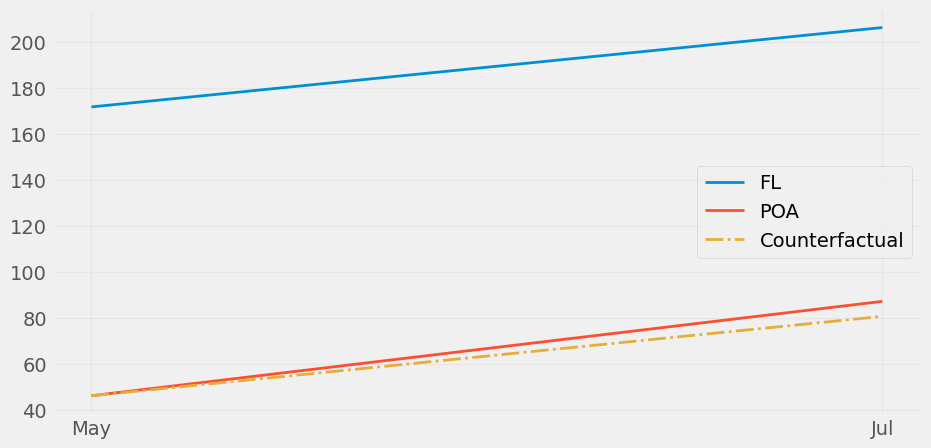

In [43]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

See that small difference between the red and the yellow dashed lines? If you really focus you can see the small treatment effect on Porto Alegre.

Now, what you might be asking yourself is "how much can I trust this estimator? It is my right to have standard errors reported to me!". Which makes sense, since estimators without them look silly. To do so, we will use a neat trick that uses regression. Specifically, we will estimate the following linear model

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

Notice that $\beta_0$ is the baseline of the control. In our case, is the level of deposits in Florianopolis in the month of May. If we turn on the treated city dummy, we get $\beta_1$. So $\beta_0 + \beta_1$ is the baseline of Porto Alegre in May, before the intervention, and $\beta_1$ is the increase of Porto Alegre baseline on top of Florianopolis. If we turn the POA dummy off and turn the July dummy on, we get $\beta_0 + \beta_2$, which is the level of Florianópolis in July, after the intervention period. $\beta_2$ is then the trend of the control, since we add it on top of the baseline to get the level of the control at the period post intervention. As a recap, $\beta_1$ is the increment we get by going from the control to the treated, $\beta_2$ is the increment we get by going from the period before to the period after the intervention. Finally, if we turn both dummies on, we get $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ is the level in Porto Alegre after the intervention. So $\beta_3$ is the incremental impact when you go from May to July and from Florianopolis to POA. In other words, it is the Difference in Difference estimator. 

If you don't believe me, check for yourself. You should get the exact same number we got above. And also notice how we get our much wanted standard errors.

In [44]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Non Parallel Trends

One obvious problem with Diff-in-Diff is failure to satisfy the parallel trend assumption. If the growth trend from the treated is different from the trend of the control, diff-in-diff will be biased. This is a common problem with non-random data, where the decision to treat a region is based on its potential to respond well to the treatment, or when the treatment is targeted at regions that are not performing very well. Take our marketing example. We decided to test billboards in Porto Alegre not in order to check the effect of billboards in general. The reason is simply because sales perform poorly there. Perhaps online marketing is not working there. In this case, it could be that the growth we would see in Porto Alegre without a billboard would be lower than the growth we observe in other cities. This would cause us to underestimate the effect of the billboard there.

One way to check if this is happening is to plot the trend using past periods. For example, let's suppose POA had a small decreasing trend but Florianopolis was on a steep ascent. In this case, showing periods from before would reveal those trends and we would know Diff-in-Diff is not a reliable estimator.

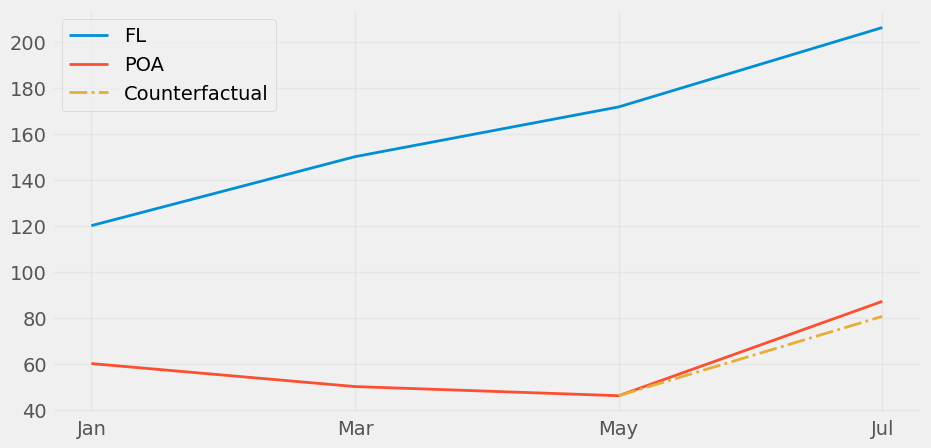

In [45]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

We will see how to solve this problem with synthetic control. It will use multiple cities to create a synthetic city that closely follows the trend of the city of interest. But for now, remember that you always need to check if you have parallel trends when applying diff-in-diff. 

One final issue that it's worth mentioning is that you won't be able to place confidence intervals around your Diff-in-Diff estimator if you only have aggregated data. Say for instance you don't have data on what each of our customers from Florianópolis or Porto Alegre did. Instead, you only have the average deposits before and after the intervention for both cities. In this case, you will still be able to estimate the causal effect by Diff-in-Diff, but you won't know the variance of it. That's because all the variability in your data got squashed out in aggregation.

## Key Ideas

We've explored a technique widely applied when we are estimating causal effects at more macro entities (schools, cities, states, countries...). Difference in Difference takes a treated unit before and after the treatment and compares the trend in the outcome to that of a control unit. Here, we've seen how this could be applied at estimating the effect of a city specific marketing campaign.

Finally, we looked at how Diff-in-Diff fails if the trend between the treated and control unit is not the same. We also saw how diff-in-diff will be problematic if we only have aggregated data.

## <a id = "p4">4.</a>  <font color = "green"> What We Learned & What's Next </font>  [back to table of contents](#top)

> As I've menteiond multiple times throughout our modules, it's always a good idea to reflect on what you've learned and put it into your own words. 

> For example, here are some potential takeaways from what we've learned above:

1. Causal Inference Revisited: We started by revisiting the key concepts of causal inference, focusing on the differences between confounders and colliders. Understanding these elements is crucial for identifying and mitigating biases that can distort our analysis.

2. A First Look at Matching with Propensity Score Matching (PSM): Next, we learned Propensity Score Matching, a popular method used to reduce bias in observational studies. PSM helps us create comparable groups based on observed characteristics, thereby approximating a randomized controlled trial (RCT).

3. Comparing Methods of Matching for Causal Inference without RCTs: We then compared different matching methods, including Inverse Probability Weighting (IPW) and Sensitivity Analysis. These techniques offer alternative ways to address confounding and enhance the validity of our causal claims when RCTs are not feasible.

4. Difference-in-Differences (DiD): Moving forward, we will discuss the Difference-in-Differences approach, which helps us determine whether observed effects are attributable to our interventions. This method leverages changes over time to isolate the impact of the intervention from other factors.

5. Further Exercise on DiD: To solidify our understanding, we will engage in practical exercises on Difference-in-Differences. These exercises are designed to reinforce the concepts learned and provide hands-on experience in applying DiD analysis.

> Throughout our lesson, we have explored various methods of causal inference, emphasizing their importance in deriving accurate conclusions from data. We began by distinguishing between confounders and colliders, laying the groundwork for understanding biases in causal analysis. Propensity Score Matching (PSM) was introduced as a technique to create balanced comparison groups, and we compared it with other methods such as Inverse Probability Weighting (IPW) and Sensitivity Analysis.

> We then examined the Difference-in-Differences (DiD) approach, highlighting its utility in determining the causal effects of interventions. Practical exercises on DiD provided an opportunity to apply the theoretical concepts and gain hands-on experience.

> `Thank you for working with the script, Team 👍`